# Research Supervisor

*The supervisor has a simple job: delegate research tasks to an appropriate number of sub-agents.*


Here is our overall research flow:

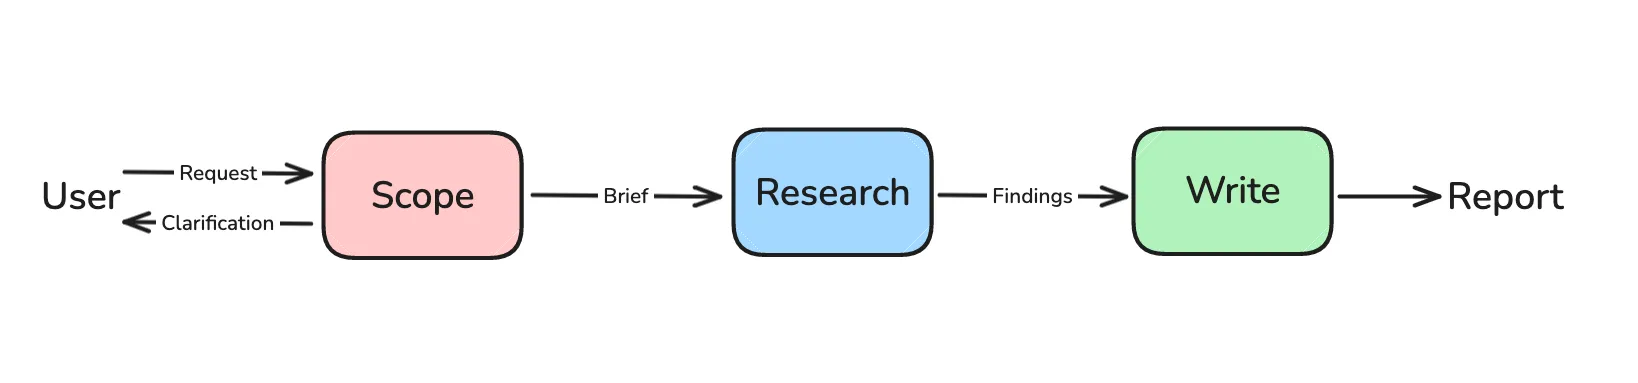

We've covered: 

1. **Scoping** - The goal of scoping is to gather user-context needed for research.
2. **Single-Agent Research** - Perform research with an agent, using either custom tools to MCP servers.

Now, we'll show how to extend this to multi-agent.

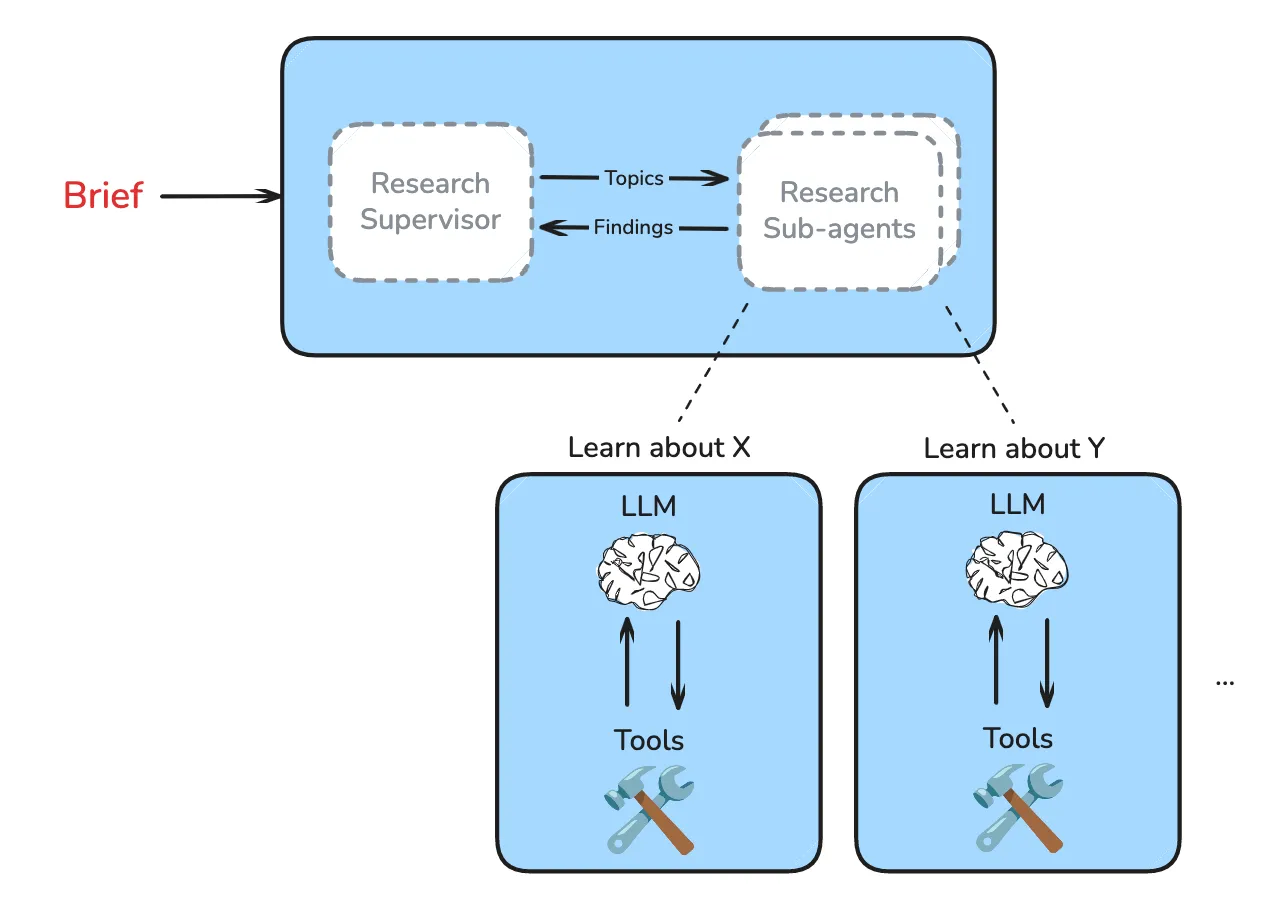

## The Case for Multi-Agent Research Systems

We previously built a research agent bound to either custom tools or MCP server. Now, what happens if the request is complex and has several sub-topics? 

Single agent response quality *can* suffer wuth multiple sub-topics (e.g., compare A to B to C) because a single context window needs to store and reason about tool feedback across all of the sub-topics. 

[Numerous failure modes](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), such as [context clash](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), become prevalent as the context window accumulates tool calls across many different sub-topics. As discussed in [Anthropic's blog post](https://www.anthropic.com/engineering/built-multi-agent-research-system), multi-agent systems can split sub-topic to sub-agents with isolated context windows.

## Supervisor Architecture

The supervisor determines if the research brief can be broken-down into independent sub-topics and delegates to sub-agents with isolated context windows. 

### Prompt

First, we'll define a prompt that instructs our agent to use available search tools. 

In [1]:
from rich.markdown import Markdown
from deep_research_from_scratch.prompts import lead_researcher_prompt
Markdown(lead_researcher_prompt)

Your job is to conduct research by calling the "ConductResearch" tool. For context, today's date is {date}.        




Parallel research saves the user time, but reason carefully about when you should use it                           

 • Calling the "ConductResearch" tool multiple times in parallel can save the user time.                           
 • You should only call the "ConductResearch" tool multiple times in parallel if the different topics that you are 
   researching can be researched independently in parallel with respect to the user's overall question.            
 • This can be particularly helpful if the user is asking for a comparison of X and Y, if the user is asking for a 
   list of entities that each can be researched independently, or if the user is asking for multiple perspectives  
   on a topic.                                                                                                     
 • Each research agent needs to be provided all of the context that is necessary to focus on a sub-topic.          
 • Do not call the "ConductResearch" tool more than {max_concurrent_research_units} times at once. This limit is   
   enforced by the user. It is perfectly fine, and expected, that you return less than this number of tool calls.  
 • If you are not confident in how you can parallelize research, you can call the "ConductResearch" tool once in   
   order to gather more background information, so you have more context to reason about if it's necessary to      
   parallelize research.                                                                                           

Different questions require different levels of research depth                                                     

 • If a user is asking a broader question, your research can be more shallow, and you may not need to iterate and  
   call the "ConductResearch" tool as many times.                                                                  
 • If a user uses terms like "detailed" or "comprehensive" in their question, you may need to be more stingy about 
   the depth of your findings, and you may need to iterate and call the "ConductResearch" tool more times to get a 
   fully detailed answer.                                                                                          

Research is expensive                                                                                              

 • Research is expensive, both from a monetary and time perspective.                                               
 • As you look at your history of tool calls, as you have conducted more and more research, the theoretical        
   "threshold" for additional research should be higher.                                                           
 • In other words, as the amount of research conducted grows, be more stingy about making even more follow-up      
   "ConductResearch" tool calls, and more willing to call "ResearchComplete" if you are satisfied with the research
   findings.                                                                                                       
 • You should only ask for topics that are ABSOLUTELY necessary to research for a comprehensive answer.            
 • Before you ask about a topic, be sure that it is substantially different from any topics that you have already  
   researched. It needs to be substantially different, not just rephrased or slightly different. The researchers   
   are quite comprehensive, so they will not miss anything.                                                        
 • When you call the "ConductResearch" tool, make sure to explicitly state how much effort you want the sub-agent  
   to put into the research. For background research, you may want it to be a shallow or small effort. For critical
   topics, you may want it to be a deep or large effort. Make the effort level explicit to the researcher.         
   </Important Guidelines>                     

### State

The supervisor state manages the overall research coordination, while the researcher state handles individual research tasks.

In [2]:
%%writefile ../src/deep_research_from_scratch/state_multi_agent_supervisor.py

import operator
from typing import Annotated, TypedDict

from pydantic import BaseModel, Field
from langchain_core.messages import MessageLikeRepresentation

def override_reducer(current_value, new_value):
    if isinstance(new_value, dict) and new_value.get("type") == "override":
        return new_value.get("value", new_value)
    else:
        return operator.add(current_value, new_value)

class SupervisorState(TypedDict):
    supervisor_messages: Annotated[list[MessageLikeRepresentation], operator.add]
    research_brief: str
    notes: Annotated[list[str], override_reducer] = []
    research_iterations: int = 0
    raw_notes: Annotated[list[str], override_reducer] = []

class ResearcherState(TypedDict):
    researcher_messages: Annotated[list[MessageLikeRepresentation], operator.add]
    tool_call_iterations: int = 0
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[list[str], override_reducer] = []

class ResearcherOutputState(BaseModel):
    compressed_research: str
    raw_notes: Annotated[list[str], override_reducer] = []

class ConductResearch(BaseModel):
    """Call this tool to conduct research on a specific topic."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

class ResearchComplete(BaseModel):
    """Call this tool to indicate that the research is complete."""

Overwriting ../src/deep_research_from_scratch/state_multi_agent_supervisor.py


### Multi-agent 

Now, we'll define our agent.

In [3]:
%%writefile ../src/deep_research_from_scratch/multi_agent_supervisor.py

"""Multi-agent supervisor for coordinating research across multiple specialized agents.

This module implements a supervisor pattern where:
1. A supervisor agent coordinates research activities and delegates tasks
2. Multiple researcher agents work on specific sub-topics independently
3. Results are aggregated and compressed for final reporting

The supervisor uses parallel research execution to improve efficiency while
maintaining isolated context windows for each research topic.
"""

import asyncio
from datetime import datetime
from typing_extensions import Literal

import nest_asyncio
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, MessageLikeRepresentation, filter_messages, SystemMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.utils import tavily_search
from deep_research_from_scratch.prompts import research_agent_prompt, compress_research_system_prompt, lead_researcher_prompt
from deep_research_from_scratch.state_multi_agent_supervisor import SupervisorState, ResearcherState, ResearcherOutputState, ConductResearch, ResearchComplete

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def get_notes_from_tool_calls(messages: list[MessageLikeRepresentation]) -> list[str]:
    """Extract notes from tool call messages."""
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

# ===== CONFIGURATION =====

# Enable nested event loops for Jupyter
nest_asyncio.apply()

# Initialize models and tools
researcher_tools = [tavily_search]
researcher_tools_by_name = {tool.name: tool for tool in researcher_tools}
researcher_model = init_chat_model(model="openai:gpt-4.1")
researcher_model_with_tools = researcher_model.bind_tools(researcher_tools)

supervisor_tools = [ConductResearch, ResearchComplete]
supervisor_model = init_chat_model(model="openai:gpt-4.1")
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# System constants
# Maximum number of tool call iterations for individual researcher agents
# This prevents infinite loops and controls research depth per topic
max_researcher_iterations = 3

# Maximum number of concurrent research agents the supervisor can launch
# This is passed to the lead_researcher_prompt to limit parallel research tasks
max_concurrent_researchers = 3

# ===== RESEARCHER NODES =====

# Researcher nodes
def researcher_llm_call(state: ResearcherState) -> Command[Literal["researcher_tool_node"]]:
    """
    Researcher agent makes decisions about what tools to call.
    
    This node processes the current conversation and decides what research
    actions to take next, such as web searches or data analysis.
    """
    messages = [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
    result = researcher_model_with_tools.invoke(messages)
    
    return Command(
        goto="researcher_tool_node",
        update={
            "researcher_messages": [result],
            "tool_call_iterations": state.get("tool_call_iterations", 0) + 1
        }
    )
    
def researcher_tool_node(state: ResearcherState) -> Command[Literal["compress_research", "researcher_llm_call"]]:
    """
    Executes tool calls made by the researcher agent.
    
    Handles async tool execution concurrently for better performance.
    Decides whether to continue research or compress findings based on
    iteration limits and completion signals.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
    
    async def execute_tools():
        # Create coroutines for all tool calls
        coros = []
        for tool_call in tool_calls:
            tool = researcher_tools_by_name[tool_call["name"]]
            coros.append(tool.ainvoke(tool_call["args"]))
        
        # Execute all tool calls concurrently
        observations = await asyncio.gather(*coros)
        
        # Create tool message outputs
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            ) for observation, tool_call in zip(observations, tool_calls)
        ]
        
        return tool_outputs
    
    # Run async function in sync context with nested event loop support
    tool_outputs = asyncio.run(execute_tools())

    # Check if research should be compressed
    should_compress = (
        state.get("tool_call_iterations", 0) >= max_researcher_iterations or 
        any(tool_call["name"] == "ResearchComplete" for tool_call in tool_calls)
    )
    
    if should_compress:
        return Command(
            goto="compress_research",
            update={"researcher_messages": tool_outputs}
        )
    
    return Command(
        goto="researcher_llm_call",
        update={"researcher_messages": tool_outputs}
    )

async def compress_research(state: ResearcherState) -> dict:
    """
    Compresses research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", [])
    
    response = await researcher_model.ainvoke(messages)
    
    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"], 
            include_types=["tool", "ai"]
        )
    ]
    
    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ===== SCOPING WORKFLOW NODES =====

# Supervisor nodes
async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """
    Supervisor agent that coordinates research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    # Prepare system message with current date and constraints
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages
    
    # Make decision about next research steps
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """
    Executes supervisor decisions - either conducts research or ends the process.
    
    Handles:
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    # Check exit criteria
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or no_tool_calls or research_complete:
        return Command(
            goto=END,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    
    # Conduct research using sub-agents
    try:
        conduct_research_calls = [
            tool_call for tool_call in most_recent_message.tool_calls 
            if tool_call["name"] == "ConductResearch"
        ]
        
        # Launch parallel research agents
        coros = [
            researcher_subgraph.ainvoke({
                "researcher_messages": [
                    HumanMessage(content=tool_call["args"]["research_topic"])
                ],
                "research_topic": tool_call["args"]["research_topic"]
            }) 
            for tool_call in conduct_research_calls
        ]
        
        # Wait for all research to complete
        tool_results = await asyncio.gather(*coros)
        
        # Format results as tool messages
        tool_messages = [
            ToolMessage(
                content=result.get("compressed_research", "Error synthesizing research report"),
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            ) for result, tool_call in zip(tool_results, conduct_research_calls)
        ]
        
        # Aggregate raw notes from all research
        all_raw_notes = [
            "\n".join(result.get("raw_notes", [])) 
            for result in tool_results
        ]
        
        return Command(
            goto="supervisor",
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )
        
    except Exception as e:
        print(f"Error in supervisor tools: {e}")
        return Command(
            goto=END,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )

# Build researcher subgraph
researcher_subgraph = StateGraph(ResearcherState, output_schema=ResearcherOutputState)
researcher_subgraph.add_node("researcher_llm_call", researcher_llm_call)
researcher_subgraph.add_node("researcher_tool_node", researcher_tool_node)
researcher_subgraph.add_node("compress_research", compress_research)
researcher_subgraph.add_edge(START, "researcher_llm_call")
researcher_subgraph.add_edge("compress_research", END)
researcher_subgraph = researcher_subgraph.compile()

# Build supervisor graph
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
agent = supervisor_builder.compile()

Overwriting ../src/deep_research_from_scratch/multi_agent_supervisor.py


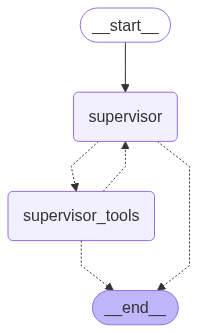

In [4]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image, display
from deep_research_from_scratch.multi_agent_supervisor import agent

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Run the multi-agent supervisor agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

Task supervisor_tools with path ('__pregel_pull', 'supervisor_tools') wrote to unknown channel branch:to:__end__, ignoring it.


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Identify and evaluate the best coffee shops in San Francisco based on coffee quality,      │
│ focusing on primary sources such as the official websites of coffee shops, reputable third-party coffee review  │
│ organizations (e.g., Coffee Review, Specialty Coffee Association), and prominent review aggregators like Google │
│ and Yelp where customer feedback about coffee quality is available. Analyze and compare the top coffee shops by │
│ coffee quality as the primary criterion, considering expert reviews, customer ratings, specialty coffee         │
│ certifications, and any industry awards or accolades related specifically to coffee quality. Present findings   │
│ as a well-supported list or ranking, emphasizing coffee quality according to the latest available data as of    │
│ July 2025. Please conduct a deep and comprehensive effort for a thorough and reliable analysis."                │
│ }                                                                                                               │
│    ID: call_sdR6AfyI005i2BMpvEiqlZYB                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│ 1. Searched Coffee Review and Coffee Review's San Francisco city guide for recent expert ratings for SF cafes   │
│ and roasters.                                                                                                   │
│ 2. Searched for 2024-2025 Specialty Coffee Association (SCA) awards and product recognition relating to San     │
│ Francisco cafes.                                                                                                │
│ 3. Scanned July 2025 Google and Yelp reviews/rankings for “best coffee” and “coffee quality” in San Francisco.  │
│ 4. Collected primary information from official websites of major SF specialty cafes (Andytown, Sightglass,      │
│ Ritual, Blue Bottle, etc.).                                                                                     │
│ 5. Included recent review and recommendation roundups from Eater SF and community threads on Reddit.            │
│ 6. Gathered evidence of certifications, accolades, direct sourcing, and customer sentiment regarding coffee     │
│ quality.                                                                                                        │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ **1. Sightglass Coffee**                                                                                        │
│ - *Expert Reviews:* Featured by Coffee Review for single-origin excellence, e.g., Colombia Finca Monte Verde;   │
│ celebrated for small-batch, meticulous roasting and high transparency ([3], [9]).                               │
│ - *Customer Sentiment:* Preferred on Yelp (4.0, 2.1k reviews) and included in every major “best-of” list ([6],  │
│ [11], [12], [13], [14], [15]).                                                                                  │
│ - *Official Website:* Focus on sourcing, sustainable practices, unique blends, and single-origin beans ([5]).   │
│ - *Industry Reputation:* Cited as a benchmark SF roaster by specialty coffee guides and Eater SF; flagship SOMA │
│ location is a destination for coffee connoisseurs ([4], [8]).                                                   │
│                                                                                                                 │
│ **2. The Coffee Movement**                                                                                      │
│ - *Customer Reviews:* Among the top-rated in SF (4.7, 691 reviews on Yelp as of July 2025) ([6]).               │
│ - *Community Accolades:* Leading vote-getter in Reddit’s “Battle of SF Coffee 2025,” indicating emerging        │
│ consensus for outstanding cup quality ([9], [10]).                                                              │
│ - *Media Coverage:* Continually included in local “best coffee” lists due to consistent, precise pour-over      │
│ service and barista skill ([8]).                                                                                │
│ - *Specialty Focus:* Known for curating a rotating roster of international guest beans for espresso and filter  │
│ service.                                                                                                        │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ResearchComplete                                                                                  │
│    Args: {}                                                                                                     │
│    ID: call_f3XOtTQs8B2dcau5ZWBKRXLI                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Eval


The main advantage to a multi-agent supervisor is that it allows us to conduct parallel research! Research is the most time-consuming part of this agent, and parallelizing research allows the agent to dig deeper without spending more time.

However, there is a cost here. Parallel research can be advantageous in some scenarios, but wholly unnecessary in others. Just like how with the researcher we needed to be intentional with when to keep calling tools vs when to finish, the supervisor needs to be intentional about when to parallelize research threads, and when not to.

Let's set up a few tests to make sure that we are parallelizing when it makes sense, and executing in a single thread when that makes more sense!

In [22]:
should_parallelize = [
    HumanMessage(content="Compare and contrast the approaches to AI safety and alignment from OpenAI, Anthropic, and DeepMind."),
]

should_not_parallelize = [
    HumanMessage(content="What are the top three chinese restaurants in Chelsea, Manhattan"),
]

In [23]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))
dataset = langsmith_client.create_dataset(
    dataset_name="supervisor_parallelism",
    description="A dataset that evaluates whether a supervisor can accurately decide when to parallelize research.",
)

langsmith_client.create_examples(
    dataset_id=dataset.id,
    examples=[
        {
            "inputs": {"supervisor_messages": should_parallelize},
            "outputs": {"num_expected_threads": 3},
        },
        {
            "inputs": {"supervisor_messages": should_not_parallelize},
            "outputs": {"num_expected_threads": 1},
        },
    ],
)

{'example_ids': ['f319f210-7121-413a-af40-dca5593c427c',
  '2cd393b6-e6ed-4ab6-8b68-effd7e1725d2'],
 'count': 2}

Awesome, now let's evaluate!

In [24]:
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await agent.nodes["supervisor"].ainvoke(inputs, config=config)

await langsmith_client.aevaluate(
    target_func,
    data="supervisor_parallelism",
    evaluators=[evaluate_parallelism],
    experiment_prefix="Supervisor Parallelism",
)

View the evaluation results for experiment: 'Supervisor Parallelism-b9eddaba' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/39d70448-bc7f-4042-b431-50c0054b50f1/compare?selectedSessions=5b317da4-49ce-43d2-9c4e-60eaf0f44ae3




0it [00:00, ?it/s]

<AsyncExperimentResults Supervisor Parallelism-b9eddaba>

In the first example, we asked the agent to compare and contrast OpenAI, Anthropic, and DeepMind's approaches to AI alignment and safety. This sort of problem is great for parallel research, and we expect the agent to deep dive into each lab in parallel before synthesizing findings when writing the report.

The second example asks the agent for the top restaurants in Chelsea, Manhattan. The agent needs to conduct a single thread of research here and reflect on websites that presumably list out highly rated restaurants. There's not an opportunity for parallelism for this ranking task.

## Lesson (TODO: @geoff review / improve)

### Evals

Try adding your own eval examples.